In [28]:
import pandas as pd
import numpy as np

df = pd.read_csv('general_tweets.csv', encoding='latin1')

In [14]:
tweets = df.values[:,0].tolist()
labels = df.values[:,1].astype(float)
print (tweets[40], labels[40])

just watched @Alicelevine on Love on @BBCiPlayer #hilarious 0.0


In [ ]:
%pip install transformers

In [29]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras import Sequential, layers
import numpy as np

In [30]:
from transformers import DistilBertTokenizer, DistilBertModel
import torch
from sklearn.model_selection import train_test_split
from keras import Sequential, layers
import numpy as np

# Load DistilBERT tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
bert_model = DistilBertModel.from_pretrained("distilbert-base-uncased")

# Generate embeddings using PyTorch
def generate_embeddings_in_batches(texts, batch_size=32):
    embeddings_list = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, padding=True, truncation=True, return_tensors="pt")
        with torch.no_grad():
            outputs = bert_model(**inputs)
            batch_embeddings = outputs.last_hidden_state.mean(dim=1).numpy()  # Mean pooling over tokens
        embeddings_list.append(batch_embeddings)
    
    # Concatenate all batch embeddings into a single array
    return np.vstack(embeddings_list)

# Generate embeddings in batches
embeddings = generate_embeddings_in_batches(tweets, batch_size=16)  # Adjust batch size if needed
print("Embeddings shape:", embeddings.shape)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, test_size=0.2, random_state=42)
print("Training set shapes:", X_train.shape, y_train.shape)
print("Test set shapes:", X_test.shape, y_test.shape)

# Define and compile the Keras classifier
classifier = Sequential([
    layers.Dense(256, activation="relu", input_shape=(X_train.shape[1],)),
    layers.Dense(1, activation="sigmoid")
])

classifier.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Train the model
history = classifier.fit(X_train, y_train, epochs=10, batch_size=16, validation_data=(X_test, y_test))


Embeddings shape: (1191, 768)
Training set shapes: (952, 768) (952,)
Test set shapes: (239, 768) (239,)
Epoch 1/10


d:\Major1\venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8790 - loss: 0.3041 - val_accuracy: 0.9540 - val_loss: 0.1271
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9530 - loss: 0.1305 - val_accuracy: 0.9665 - val_loss: 0.0914
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9776 - loss: 0.0724 - val_accuracy: 0.9749 - val_loss: 0.0730
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9773 - loss: 0.0638 - val_accuracy: 0.9749 - val_loss: 0.0630
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9850 - loss: 0.0492 - val_accuracy: 0.9665 - val_loss: 0.0694
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9898 - loss: 0.0381 - val_accuracy: 0.9874 - val_loss: 0.0528
Epoch 7/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9863 - loss: 0.0358 - val_accuracy: 0.9749 - val_loss: 0.0634
Epoch 8/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9882 - loss: 0.0273 - val_accuracy: 0.9874 - val_loss: 0.0534
Epo

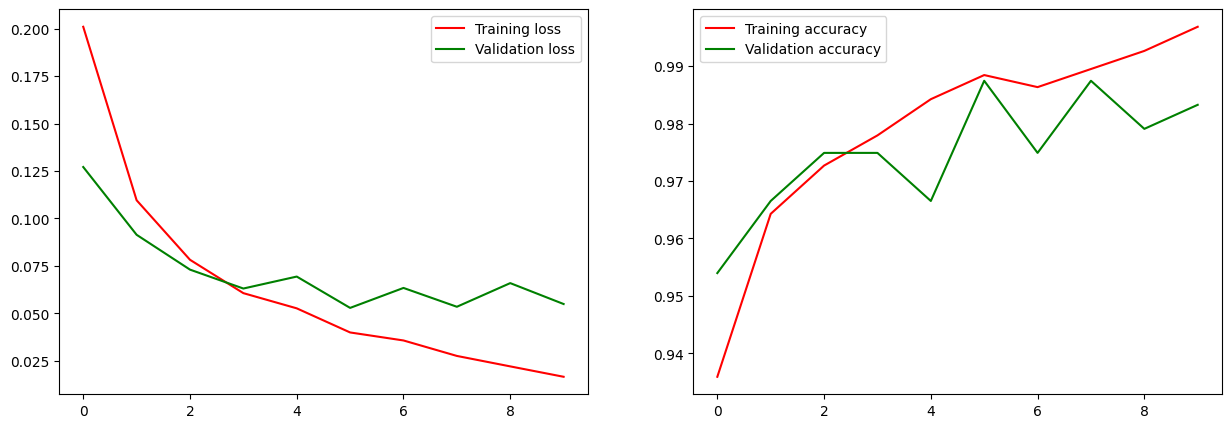

In [31]:
from matplotlib import pyplot

pyplot.figure(figsize=(15,5))
pyplot.subplot(1, 2, 1)
pyplot.plot(history.history['loss'], 'r', label='Training loss')
pyplot.plot(history.history['val_loss'], 'g', label='Validation loss')
pyplot.legend()
pyplot.subplot(1, 2, 2)
pyplot.plot(history.history['accuracy'], 'r', label='Training accuracy')
pyplot.plot(history.history['val_accuracy'], 'g', label='Validation accuracy')
pyplot.legend()
pyplot.show()

In [32]:
y_pred = classifier.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


In [33]:
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99       228
         1.0       1.00      0.64      0.78        11

    accuracy                           0.98       239
   macro avg       0.99      0.82      0.88       239
weighted avg       0.98      0.98      0.98       239



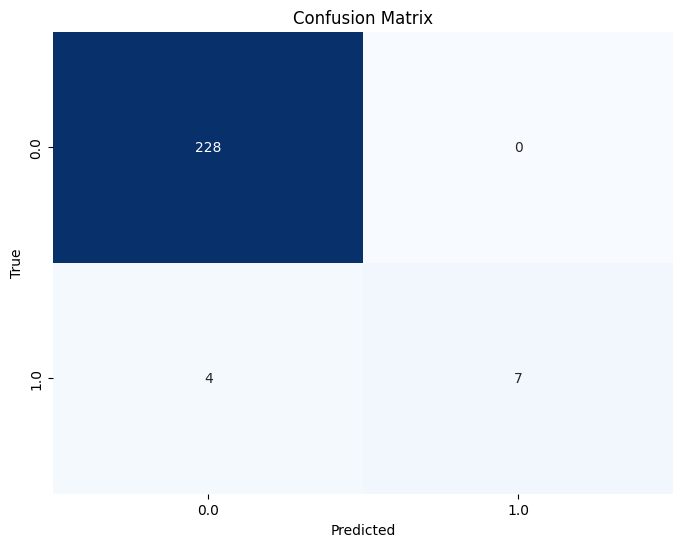

In [34]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
class_labels = np.unique(y_test)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [35]:
classifier.save('mybert.h5')

In [36]:
# Saving embeddings with PyTorch
import torch
torch.save(embeddings, "mybert_embeddings.pt")